In [45]:
from __future__ import print_function

import numpy as np
import yt
import unyt
from yt.units import *
from yt import YTArray
import argparse
import os
import glob
import sys
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
import random
#from photutils import detect_threshold, detect_sources, source_properties, EllipticalAperture
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import minimize
import trident
import ast
#import emcee
import numpy.random as rn
from multiprocessing import Pool
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from yt.units import kpc, cm

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import h5py
import matplotlib.cm as mtcm

def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/halo_008508/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
halo = '8508'
run = 'ludicrous/nref13c_nref9f.enhance'
snap = 'DD2509'
halo_name = 'Tempest'

foggie_dir,code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_43362/789615977.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set3', len(bin_sizes))  # Using 'viridis' colormap with the number of colors equal to bin_sizes length


/Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/
/Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/FRBs/res_6.1/Tempest_emission_maps.hdf5


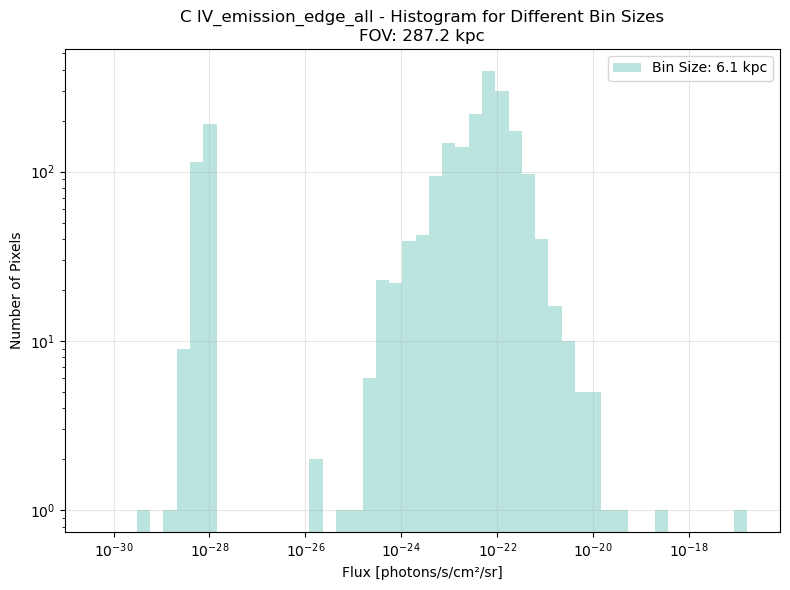

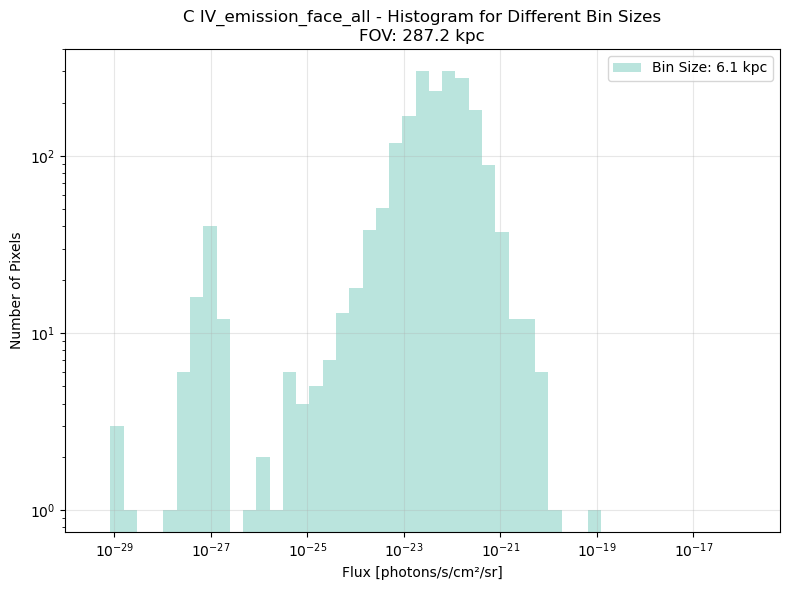

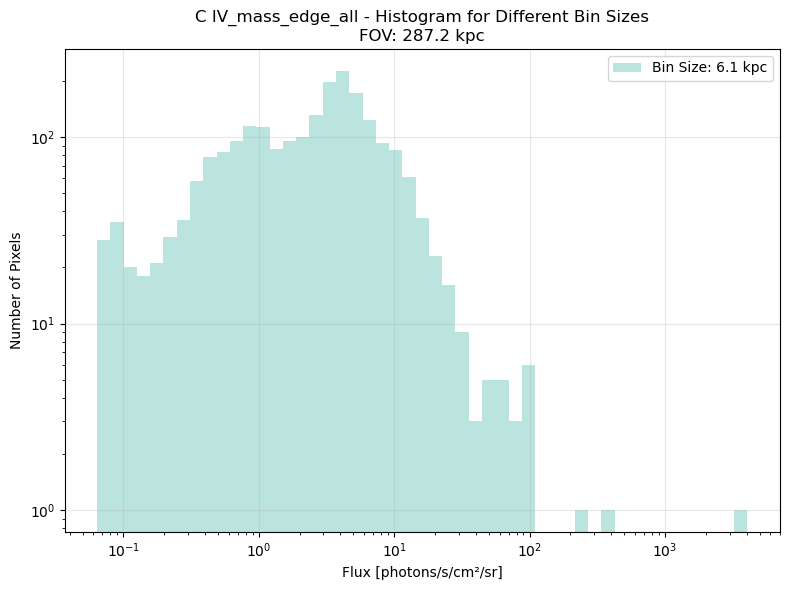

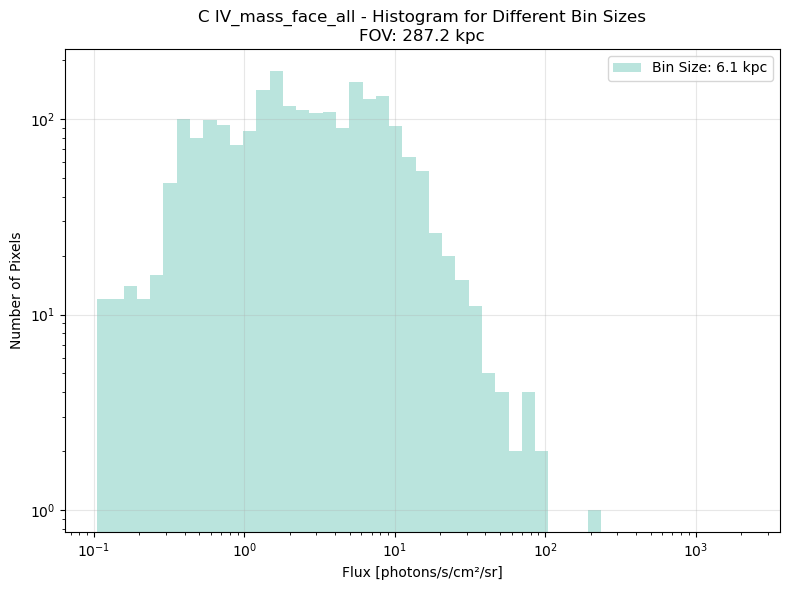

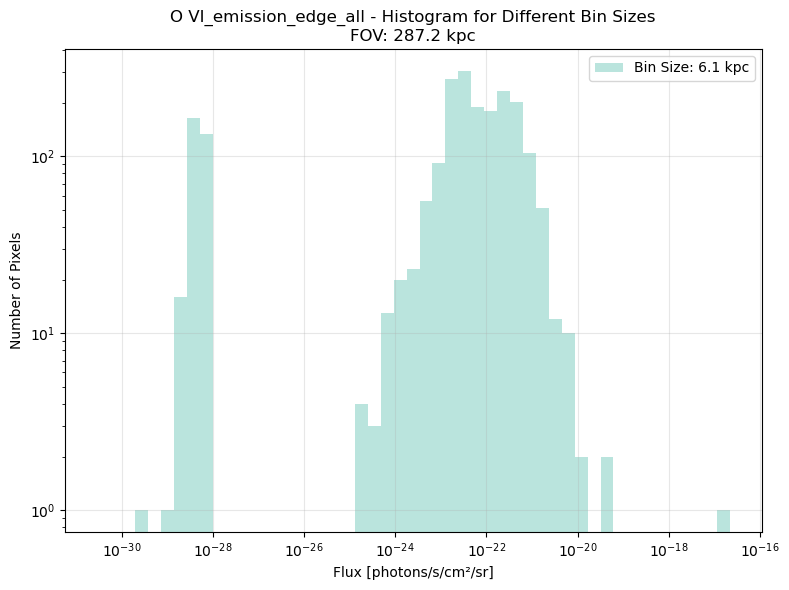

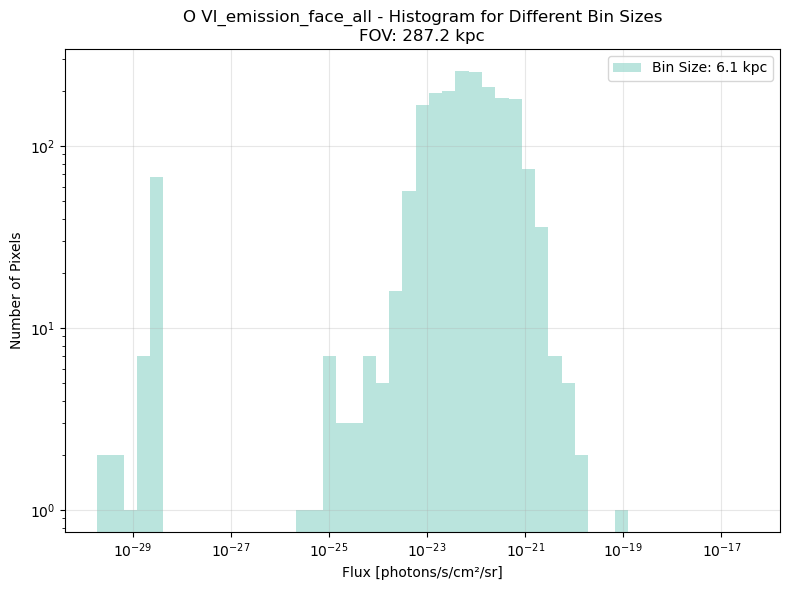

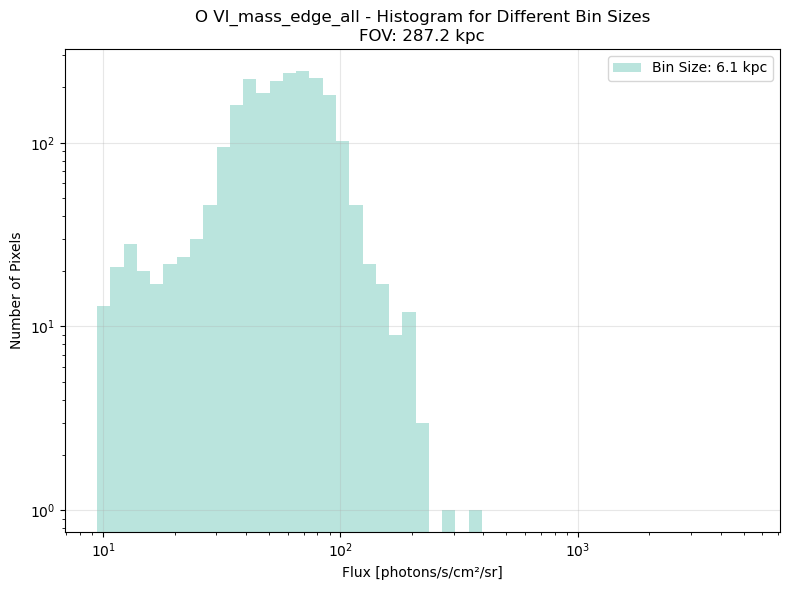

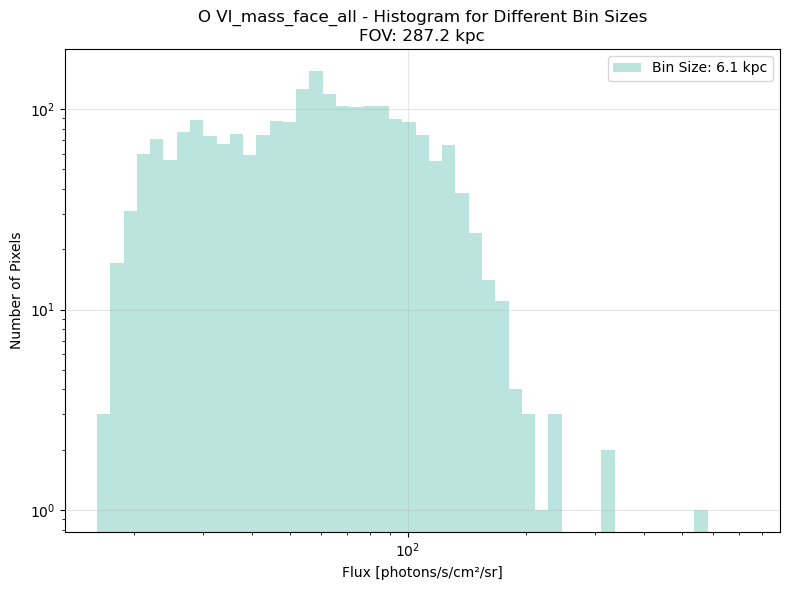

In [46]:
bin_sizes = ['6.1']#['0.2','0.4','2.0','5.0','6.1']
cmap = mtcm.get_cmap('Set3', len(bin_sizes))  # Using 'viridis' colormap with the number of colors equal to bin_sizes length

prefix = output_dir + '/' + 'ions_halo_00' + halo + '/' + run + '/'
print(prefix)
# Extract all dataset names dynamically from one of the HDF5 files
example_bin_size = bin_sizes[0]
example_save_path = prefix + f'FRBs/res_{example_bin_size}/'
example_file_path = example_save_path + halo_name + '_emission_maps' + '.hdf5'
print(example_file_path)
# Open the example HDF5 file to get the dataset names
with h5py.File(example_file_path, 'r') as example_file:
    set_of_datasets = list(next(iter(example_file.values())).keys())  # Extract dataset names

# Iterate over datasets
for dataset_name in set_of_datasets:
    plt.figure(figsize=(8, 6))  # Initialize the figure for each dataset

    for i, bin_size_kpc in enumerate(bin_sizes):
        color = cmap(i)  # Choose color from colormap based on index
        save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
        file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

        # Open the HDF5 file and iterate through redshifts and datasets
        with h5py.File(file_path, 'r') as f:
            for redshift_group in f.keys():  # Iterate through redshift groups
                redshift_data = f[redshift_group]

                # Extract FOV, resolution, and bin size from the attributes
                fov_kpc = redshift_data.attrs.get("image_extent_kpc", "FOV Unknown")
                resolution = redshift_data.attrs.get("number_of_bins", "Unknown")

                if fov_kpc != "FOV Unknown":
                    fov_kpc = round(fov_kpc, 1)  # Round FOV to one decimal place

                # Get the dataset for the current bin size
                if dataset_name in redshift_data.keys():
                    emission_data = np.array(redshift_data[dataset_name])

                    # Flatten the emission data to calculate flux per pixel
                    flux_per_pixel = emission_data.flatten()

                    # Define log-spaced bins
                    flux_min = flux_per_pixel[flux_per_pixel > 1e-40].min()  # Avoid bins starting at 0
                    flux_max = flux_per_pixel.max()
                    bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 50)  # 50 log-spaced bins

                    # Add histogram for this bin size
                    plt.hist(flux_per_pixel, bins=bins, color=color, alpha=0.6,
                             label=f'Bin Size: {bin_size_kpc} kpc')
    
    # Finalize the plot for this dataset
    plt.yscale('log')  # Use logarithmic scale for better visibility
    plt.xscale('log')  # Log scale for x-axis
    plt.xlabel('Flux [photons/s/cm²/sr]')
    plt.ylabel('Number of Pixels')
    plt.title(f'{dataset_name} - Histogram for Different Bin Sizes\nFOV: {fov_kpc} kpc')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the combined plot in a directory for all resolutions
    combined_dir = os.path.join(prefix, "combined_histograms", redshift_group,"smearbinning")
    os.makedirs(combined_dir, exist_ok=True)
    plt.savefig(os.path.join(combined_dir, f"{dataset_name}_combined_histogram.png"))
    plt.show()
    plt.close()


In [44]:
# Open the HDF5 file in read mode
with h5py.File(file_path, 'r') as f:
    # Recursively print all groups and datasets in the file
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name}, Shape: {obj.shape}, Data Type: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"Group: {name}")
    
    f.visititems(print_structure)

Group: z=0.0
Dataset: z=0.0/C IV_emission_edge_all, Shape: (47, 47), Data Type: float64
Dataset: z=0.0/C IV_emission_face_all, Shape: (47, 47), Data Type: float64
Dataset: z=0.0/C IV_mass_edge_all, Shape: (47, 47), Data Type: float64
Dataset: z=0.0/C IV_mass_face_all, Shape: (47, 47), Data Type: float64
Dataset: z=0.0/O VI_emission_edge_all, Shape: (47, 47), Data Type: float64
Dataset: z=0.0/O VI_emission_face_all, Shape: (47, 47), Data Type: float64
Dataset: z=0.0/O VI_mass_edge_all, Shape: (47, 47), Data Type: float64
Dataset: z=0.0/O VI_mass_face_all, Shape: (47, 47), Data Type: float64


/Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/
/Users/vidasaeedzadeh/Projects/foggie_outputs//ions_halo_008508/ludicrous/nref13c_nref9f.enhance/FRBs/res_0.2/Tempest_emission_maps.hdf5


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_43362/2907436200.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set3', len(bin_sizes))  # Colormap for different bin sizes
/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_43362/2907436200.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


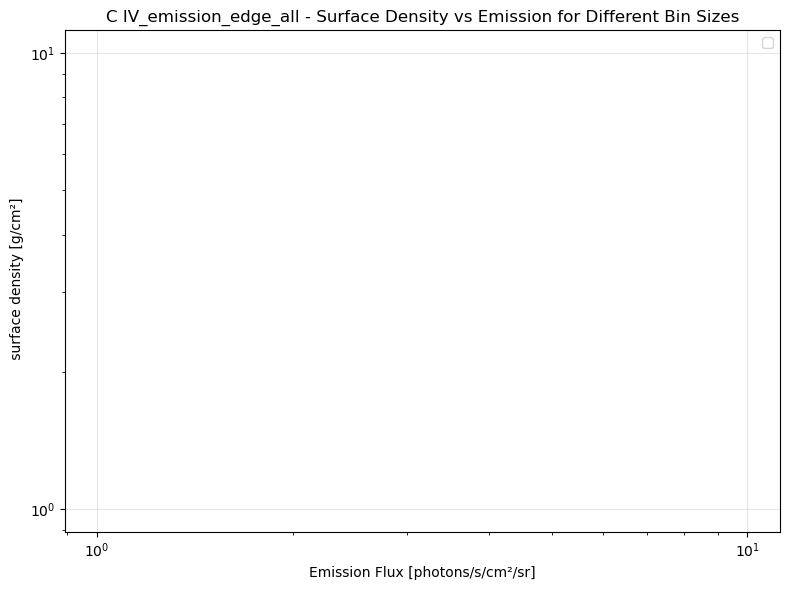

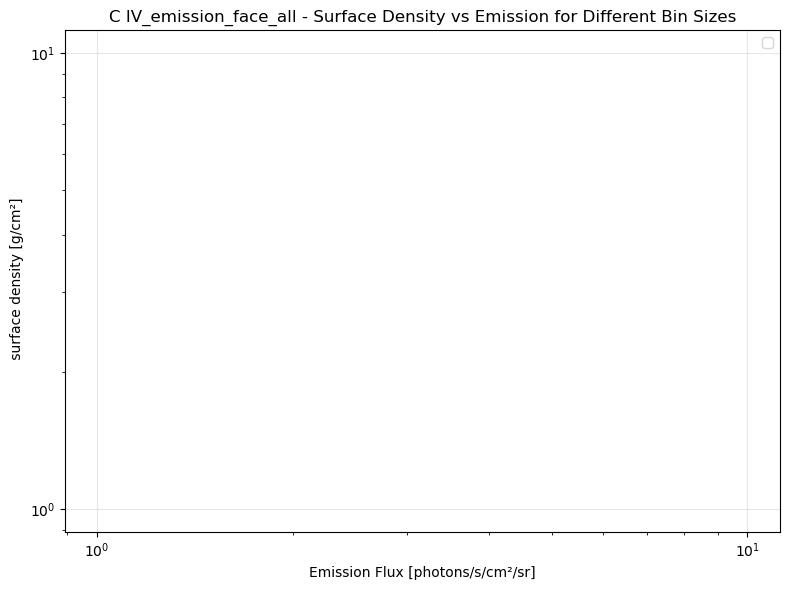

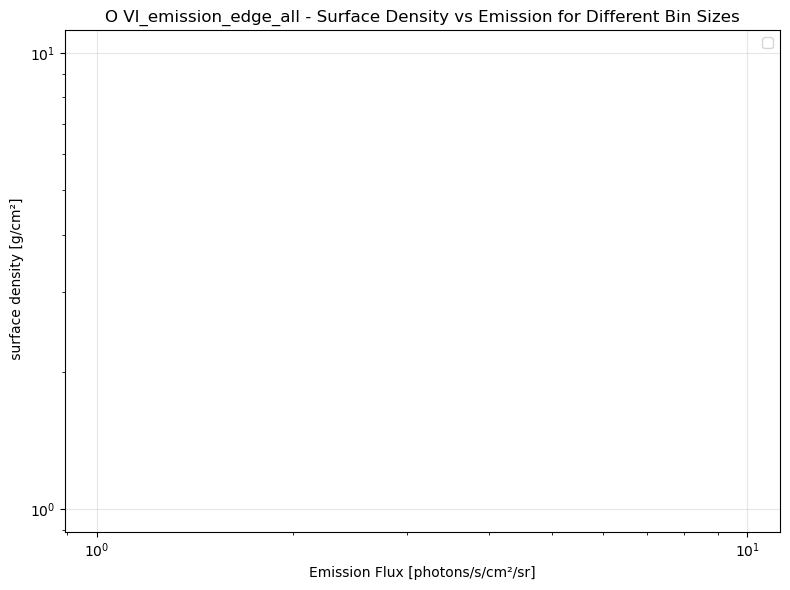

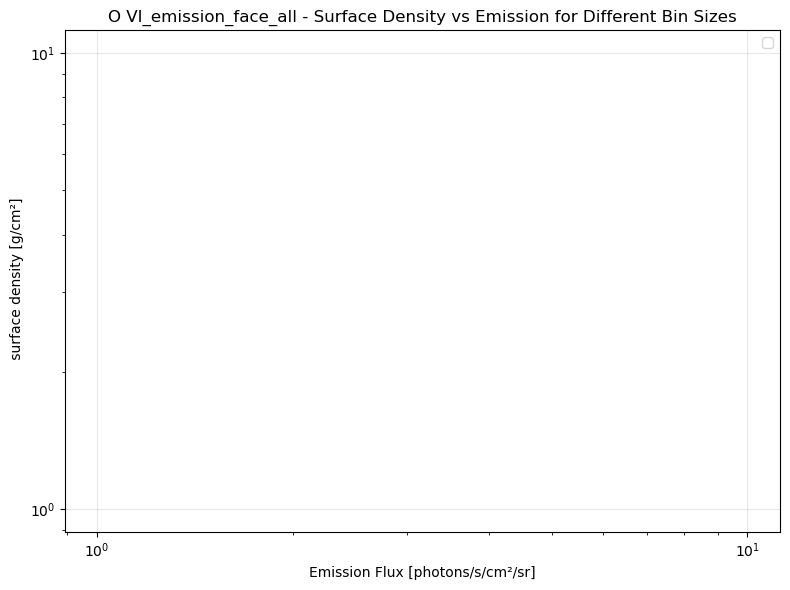

In [47]:
bin_sizes = ['0.2','0.4','2.0','6.1']
cmap = mtcm.get_cmap('Set3', len(bin_sizes))  # Colormap for different bin sizes

prefix = output_dir + '/' + 'ions_halo_00' + halo + '/' + run + '/'
print(prefix)

# Extract all dataset names dynamically from one of the HDF5 files
bin_size = bin_sizes[0]
save_path = prefix + f'FRBs/res_{bin_size}/'
file_path = save_path + halo_name + '_emission_maps' + '.hdf5'
print(file_path)

# Open the  HDF5 file to get the dataset names
with h5py.File(file_path, 'r') as file:
    set_of_datasets = list(next(iter(file.values())).keys())  # Extract dataset names

# Iterate over datasets
for dataset_name in set_of_datasets:
    if "emission" in dataset_name:  # Process only emission datasets
        plt.figure(figsize=(8, 6))  # Initialize the figure for each dataset

        for i, bin_size_kpc in enumerate(bin_sizes):
            color = cmap(i)  # Choose color from colormap based on index
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and iterate through redshifts and datasets
            with h5py.File(file_path, 'r') as f:
                for redshift_group in f.keys():  # Iterate through redshift groups
                    redshift_data = f[redshift_group]

                    # Get the dataset for the current bin size
                    if dataset_name in redshift_data.keys():
                        emission_data = np.array(redshift_data[dataset_name]).flatten()
                        surface_density_name = dataset_name.replace("emission", "surfacedensity")

                        # Check if the corresponding surface density dataset exists
                        if surface_density_name in redshift_data.keys():
                            surface_density_data = np.array(redshift_data[surface_density_name]).flatten()

                            # Filter valid values
                            valid_indices = (emission_data > 1e-40) & (surface_density_data > 1e-40)
                            emission_data = emission_data[valid_indices]
                            surface_density_data = surface_density_data[valid_indices]

                            # Define log-spaced bins
                            flux_min = emission_data.min()
                            flux_max = emission_data.max()
                            bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 50)

                            # Calculate total surface density per bin
                            bin_indices = np.digitize(emission_data, bins)
                            surface_density_per_bin = [
                                surface_density_data[bin_indices == j].sum() for j in range(1, len(bins))
                            ]

                            # Plot filled histogram for this bin size
                            bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Bin centers for plotting
                            plt.fill_between(
                                bin_centers, surface_density_per_bin, step='mid', color=color, alpha=0.6,
                                label=f'Bin Size: {bin_size_kpc} kpc'
                            )

        # Finalize the plot for this dataset
        plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.xlabel('Emission Flux [photons/s/cm²/sr]')
        plt.ylabel(' surface density [g/cm²]')
        plt.title(f'{dataset_name} - Surface Density vs Emission for Different Bin Sizes')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the combined plot in a directory for all resolutions
        combined_dir = os.path.join(prefix, "combined_histograms", redshift_group, "smearbinning")
        os.makedirs(combined_dir, exist_ok=True)
        plt.savefig(os.path.join(combined_dir, f"{dataset_name}_combined_histogram.png"))
        plt.show()
        plt.close()


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_43362/878264412.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set1', 10)


ion C IV
orientation edge
total mass 11722.882028345937
total mass 11691.750352650693
total mass 11131.484144740287
total mass 14889.770316500933


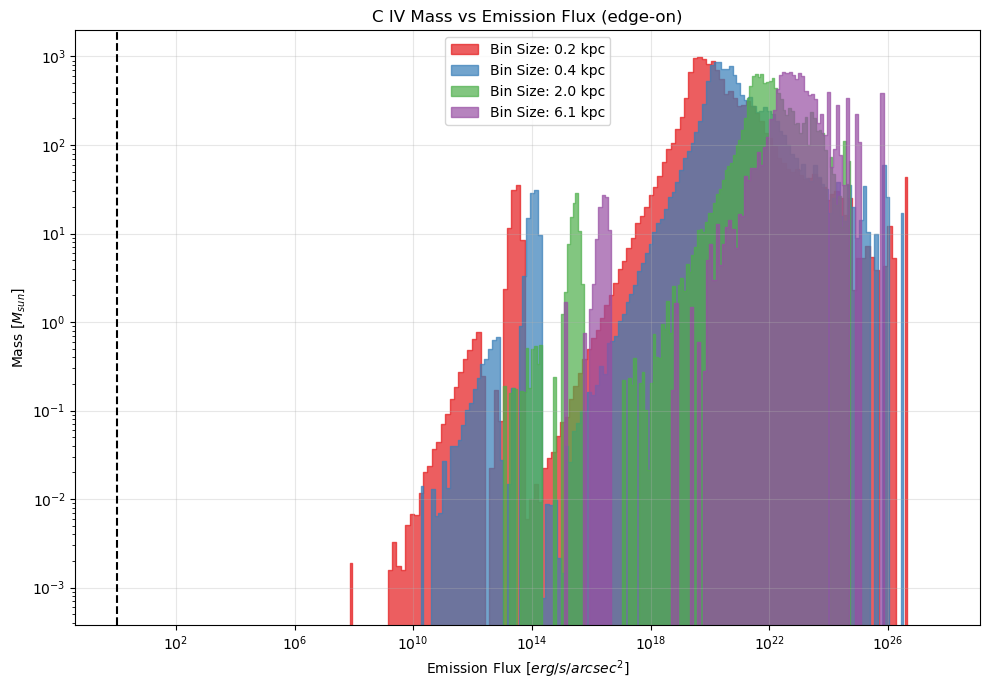

orientation face
total mass 11667.793067260804
total mass 11682.81659237289
total mass 11297.080547297488
total mass 13020.844731656785


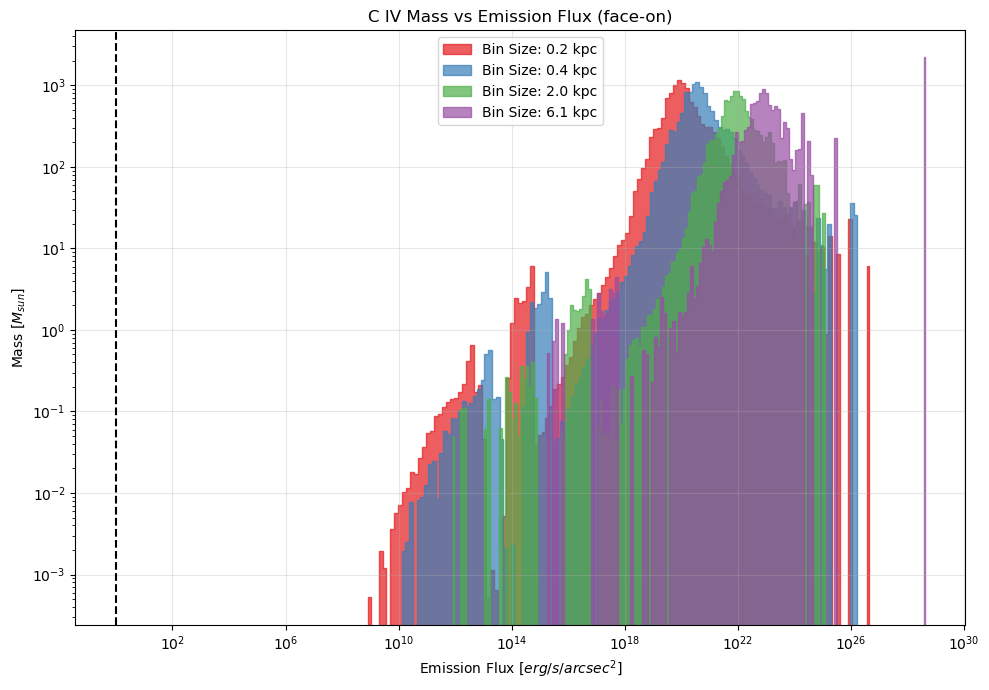

ion O VI
orientation edge
total mass 138348.15559911978
total mass 138289.95294587407
total mass 137398.71063515823
total mass 140599.88012825942


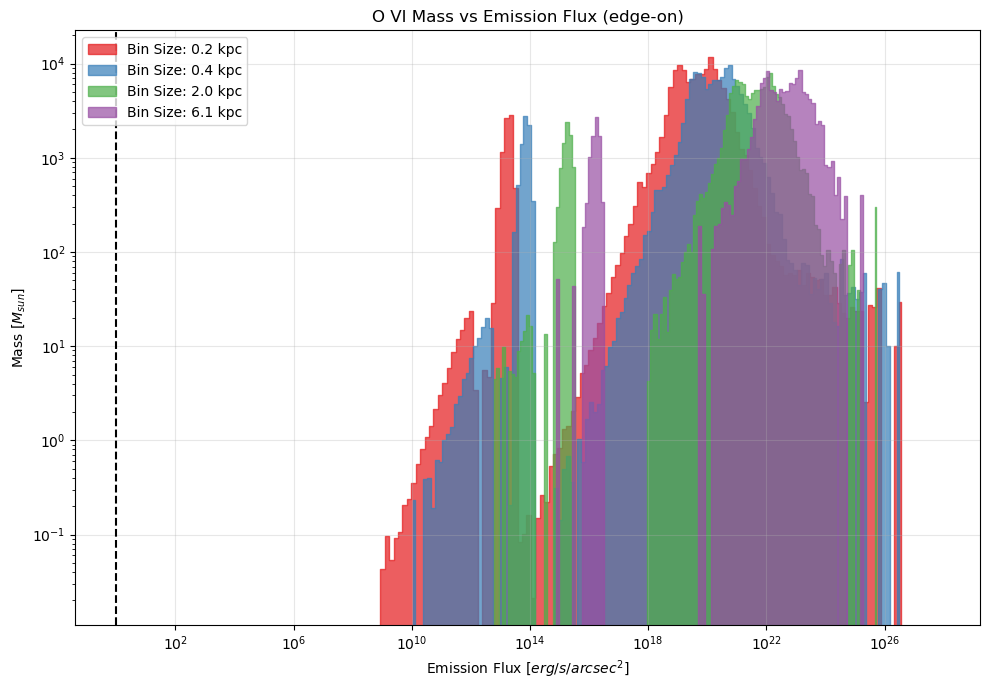

orientation face
total mass 145796.01531898553
total mass 145672.11782417048
total mass 144886.6911192898
total mass 143299.73024456683


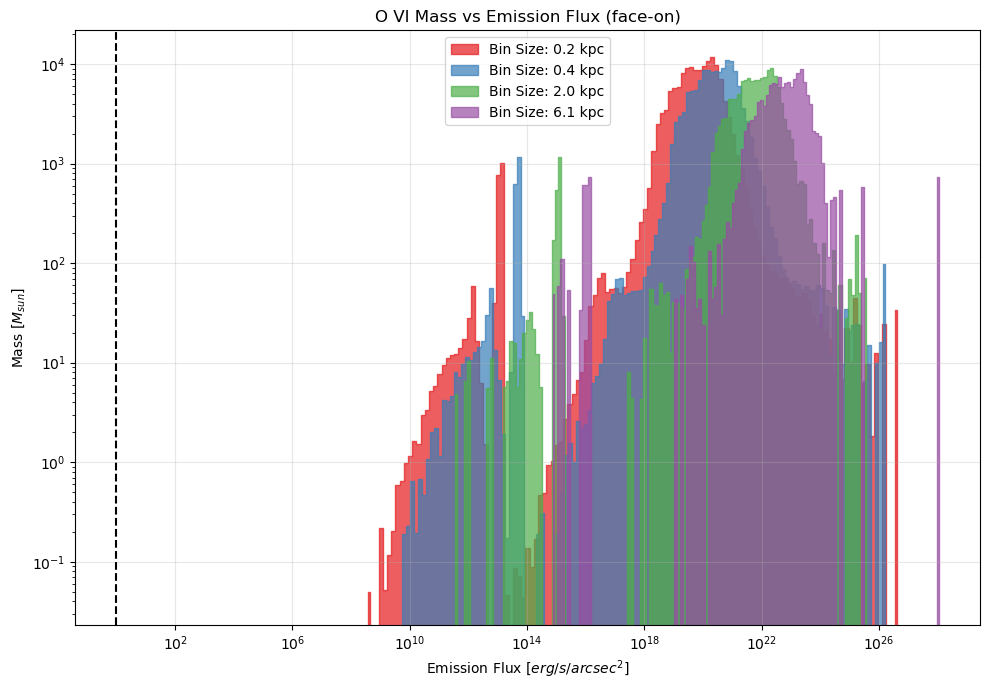

In [61]:
# Iterate over ions and orientations
ions = ["C IV", "O VI"]
orientations = ["edge", "face"]
bin_sizes = ['0.2','0.4','2.0','6.1']
cmap = mtcm.get_cmap('Set1', 10)
for ion in ions:
    print('ion',ion)
    for orientation in orientations:
        print('orientation',orientation)
        plt.figure(figsize=(10, 7))
        
        # Dataset names for mass and emission
        mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
        emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"

        for i, bin_size_kpc in enumerate(bin_sizes):
            color = cmap(i)  # Select color from colormap
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract mass and emission data
            with h5py.File(file_path, 'r') as f:
                mass_data = np.array(f[mass_dataset_name]).flatten()
                emission_data = np.array(f[emission_dataset_name]).flatten()
                total_mass = mass_data.sum()
                print('total mass',total_mass)

                # Filter valid values
                valid_indices = (emission_data > 1e-40) & (mass_data > 1e-40)
                emission_data = emission_data[valid_indices]*((float(bin_size_kpc)*3.086e21)**2)
                mass_data = mass_data[valid_indices]

                # Define log-spaced bins for emission
                flux_min = emission_data.min()
                flux_max = emission_data.max()
                bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 128)

                # Calculate total mass per bin
                bin_indices = np.digitize(emission_data, bins)
                mass_per_bin = [mass_data[bin_indices == j].sum() for j in range(1, len(bins))]

                # Plot the results
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                plt.fill_between(bin_centers, mass_per_bin, step='mid', color=color, alpha=0.7,
                                    label=f'Bin Size: {bin_size_kpc} kpc')

        # Finalize the plot for this ion and orientation
        plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.xlabel('Emission Flux [$erg/s/arcsec^2$]')
        plt.ylabel('Mass [$M_{sun}$]')
        plt.axvline(x = 1, color='k', linestyle='--')
        plt.title(f'{ion} Mass vs Emission Flux ({orientation}-on)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "mass_vs_emission_plots", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_mass_vs_emission.png"))
        plt.show()
        plt.close()


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_43362/4158344364.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set1', 10)


ion C IV
orientation edge
total mass 11722.882028345937
total mass 11691.750352650693
total mass 11131.484144740287
total mass 14889.770316500933


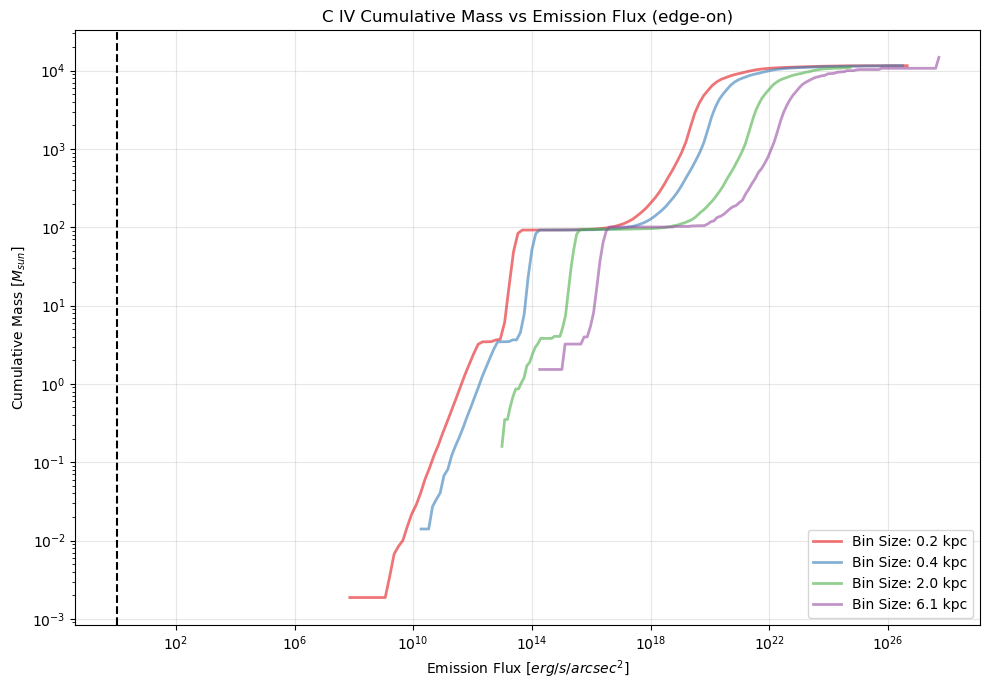

orientation face
total mass 11667.793067260804
total mass 11682.81659237289
total mass 11297.080547297488
total mass 13020.844731656785


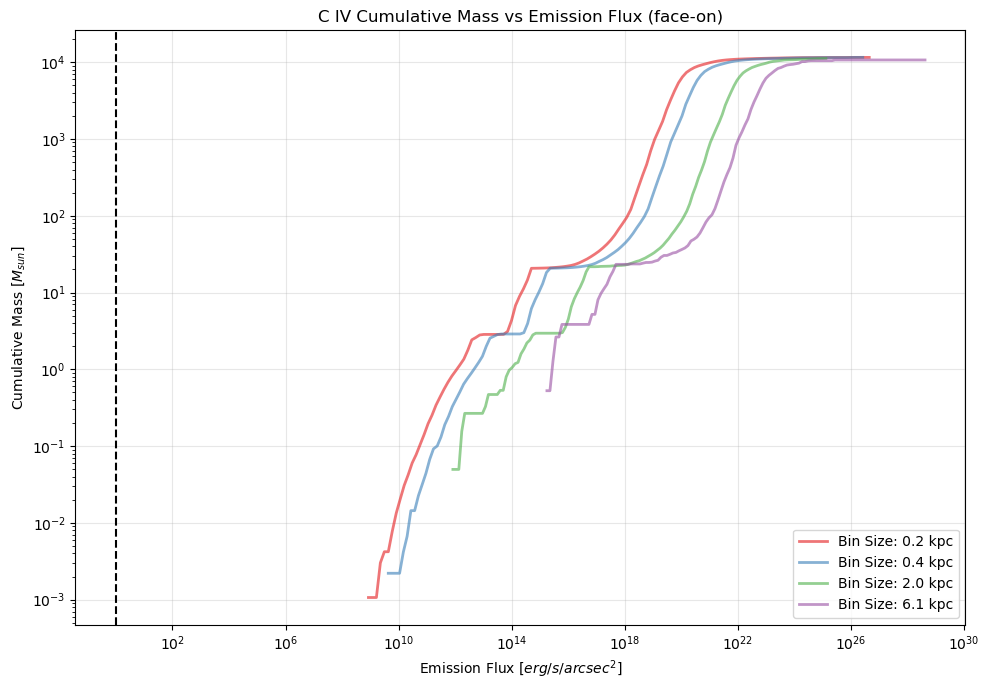

ion O VI
orientation edge
total mass 138348.15559911978
total mass 138289.95294587407
total mass 137398.71063515823
total mass 140599.88012825942


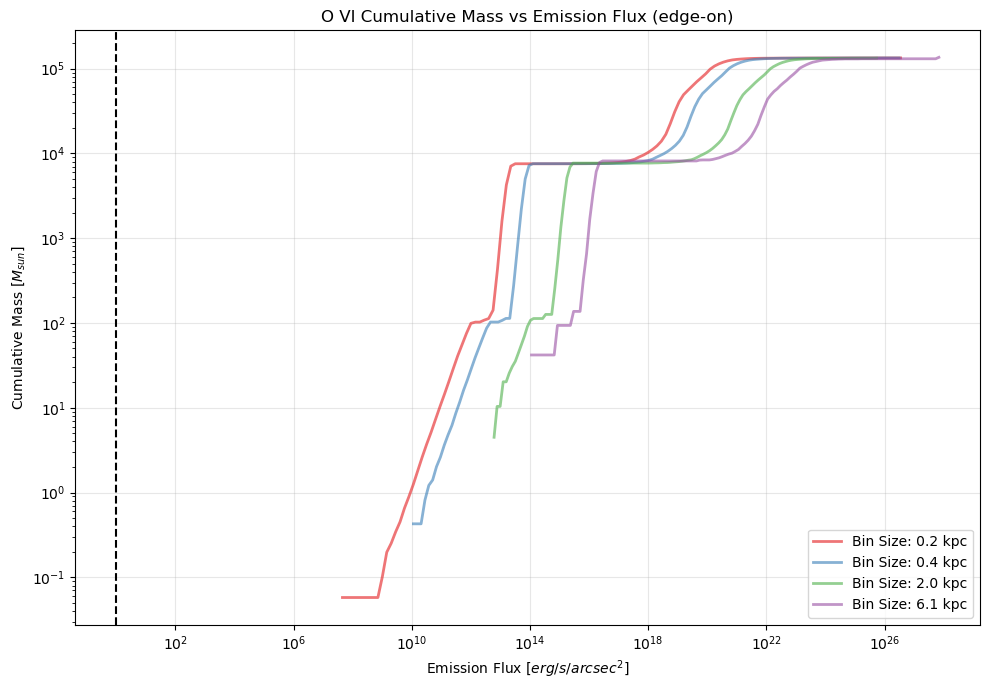

orientation face
total mass 145796.01531898553
total mass 145672.11782417048
total mass 144886.6911192898
total mass 143299.73024456683


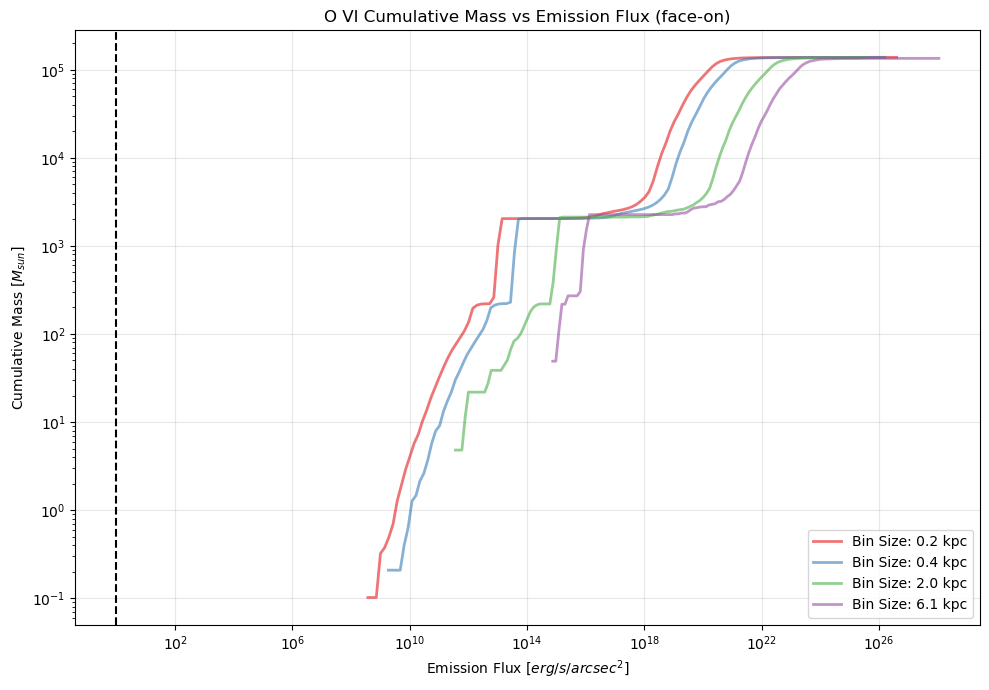

In [62]:
# Iterate over ions and orientations
ions = ["C IV", "O VI"]
orientations = ["edge", "face"]
bin_sizes = ['0.2', '0.4', '2.0', '6.1']
cmap = mtcm.get_cmap('Set1', 10)
for ion in ions:
    print('ion', ion)
    for orientation in orientations:
        print('orientation', orientation)
        plt.figure(figsize=(10, 7))

        # Dataset names for mass and emission
        mass_dataset_name = f"z=0.0/{ion}_mass_{orientation}_all"
        emission_dataset_name = f"z=0.0/{ion}_emission_{orientation}_all"

        for i, bin_size_kpc in enumerate(bin_sizes):
            color = cmap(i)  # Select color from colormap
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract mass and emission data
            with h5py.File(file_path, 'r') as f:
                mass_data = np.array(f[mass_dataset_name]).flatten()
                emission_data = np.array(f[emission_dataset_name]).flatten()
                total_mass = mass_data.sum()
                print('total mass', total_mass)

                
                # Use yt units to convert bin size and compute area
                bin_size = float(bin_size_kpc) * kpc  # Bin size in kpc
                bin_area = bin_size.to(cm)**2  # Area in cm^2

                # Filter valid values
                # Multiply surface brightness to get brightness
                valid_indices = (emission_data > 1e-40) & (mass_data > 1e-40)
                emission_data = emission_data[valid_indices] * bin_area
                mass_data = mass_data[valid_indices]

                # Define log-spaced bins for emission
                flux_min = emission_data.min()
                flux_max = emission_data.max()
                bins = np.logspace(np.log10(flux_min), np.log10(flux_max), 128)

                # Calculate cumulative mass for each bin
                bin_indices = np.digitize(emission_data, bins)
                cumulative_mass = np.array([mass_data[bin_indices <= j].sum() for j in range(1, len(bins))])

                # Plot the cumulative results
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                plt.plot(bin_centers, cumulative_mass, color=color, alpha=0.6, label=f'Bin Size: {bin_size_kpc} kpc', lw = 2)

        # Finalize the plot for this ion and orientation
        plt.yscale('log')  # Logarithmic scale for y-axis
        plt.xscale('log')  # Logarithmic scale for x-axis
        plt.xlabel('Emission Flux [$erg/s/arcsec^2$]')
        plt.ylabel('Cumulative Mass [$M_{sun}$]')
        plt.axvline(x=1, color='k', linestyle='--')
        plt.title(f'{ion} Cumulative Mass vs Emission Flux ({orientation}-on)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "mass_vs_emission_plots", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_cumulative_mass_vs_emission.png"))
        plt.show()
        plt.close()


Ion: C IV
Orientation: edge
emission_data min 60650121.80010668
Bin Size: 0.2 kpc
Total Flux: 1.54e+27, Flux Above Threshold: 1.41e+27, Flux Ratio: 0.91
Total Mass: 1.16e+04, Mass Above Threshold: 9.62e+02, Mass Ratio: 0.08
emission_data min 15658262327.906076
Bin Size: 0.4 kpc
Total Flux: 1.13e+27, Flux Above Threshold: 1.02e+27, Flux Ratio: 0.91
Total Mass: 1.16e+04, Mass Above Threshold: 1.72e+03, Mass Ratio: 0.15
emission_data min 8733773133274.703
Bin Size: 2.0 kpc
Total Flux: 1.84e+26, Flux Above Threshold: 1.46e+26, Flux Ratio: 0.79
Total Mass: 1.10e+04, Mass Above Threshold: 5.46e+03, Mass Ratio: 0.50
emission_data min 160994140209904.53
Bin Size: 6.1 kpc
Total Flux: 6.06e+27, Flux Above Threshold: 6.06e+27, Flux Ratio: 1.00
Total Mass: 1.48e+04, Mass Above Threshold: 1.40e+04, Mass Ratio: 0.95


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_43362/2887406272.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set1', len(bin_sizes))  # Colormap for plots


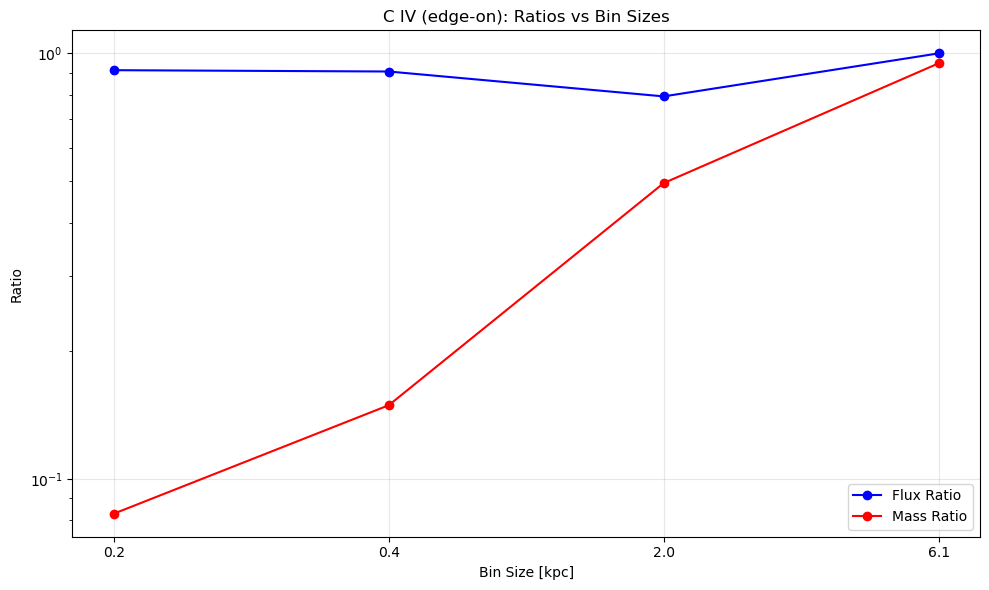

Orientation: face
emission_data min 720331411.715627
Bin Size: 0.2 kpc
Total Flux: 1.39e+27, Flux Above Threshold: 1.24e+27, Flux Ratio: 0.89
Total Mass: 1.16e+04, Mass Above Threshold: 6.30e+02, Mass Ratio: 0.05
emission_data min 3659933528.111297
Bin Size: 0.4 kpc
Total Flux: 1.11e+27, Flux Above Threshold: 9.84e+26, Flux Ratio: 0.89
Total Mass: 1.16e+04, Mass Above Threshold: 1.16e+03, Mass Ratio: 0.10
emission_data min 732621580624.2316
Bin Size: 2.0 kpc
Total Flux: 2.36e+26, Flux Above Threshold: 1.95e+26, Flux Ratio: 0.83
Total Mass: 1.12e+04, Mass Above Threshold: 5.52e+03, Mass Ratio: 0.49
emission_data min 1550732468183475.5
Bin Size: 6.1 kpc
Total Flux: 4.67e+28, Flux Above Threshold: 4.67e+28, Flux Ratio: 1.00
Total Mass: 1.29e+04, Mass Above Threshold: 1.20e+04, Mass Ratio: 0.93


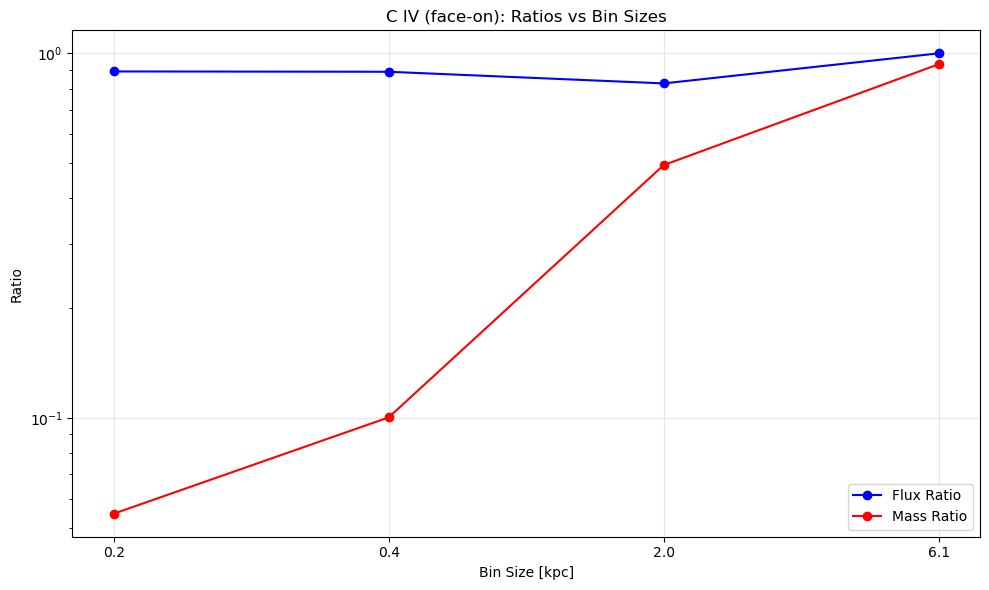

Ion: O VI
Orientation: edge
emission_data min 37147015.7566996
Bin Size: 0.2 kpc
Total Flux: 1.90e+27, Flux Above Threshold: 1.70e+27, Flux Ratio: 0.90
Total Mass: 1.34e+05, Mass Above Threshold: 1.22e+03, Mass Ratio: 0.01
emission_data min 9590380038.0536
Bin Size: 0.4 kpc
Total Flux: 1.50e+27, Flux Above Threshold: 1.33e+27, Flux Ratio: 0.89
Total Mass: 1.34e+05, Mass Above Threshold: 2.83e+03, Mass Ratio: 0.02
emission_data min 5349265567289.006
Bin Size: 2.0 kpc
Total Flux: 3.65e+26, Flux Above Threshold: 3.34e+26, Flux Ratio: 0.92
Total Mass: 1.33e+05, Mass Above Threshold: 4.70e+04, Mass Ratio: 0.35
emission_data min 98605768391104.98
Bin Size: 6.1 kpc
Total Flux: 7.94e+27, Flux Above Threshold: 7.94e+27, Flux Ratio: 1.00
Total Mass: 1.36e+05, Mass Above Threshold: 9.90e+04, Mass Ratio: 0.73


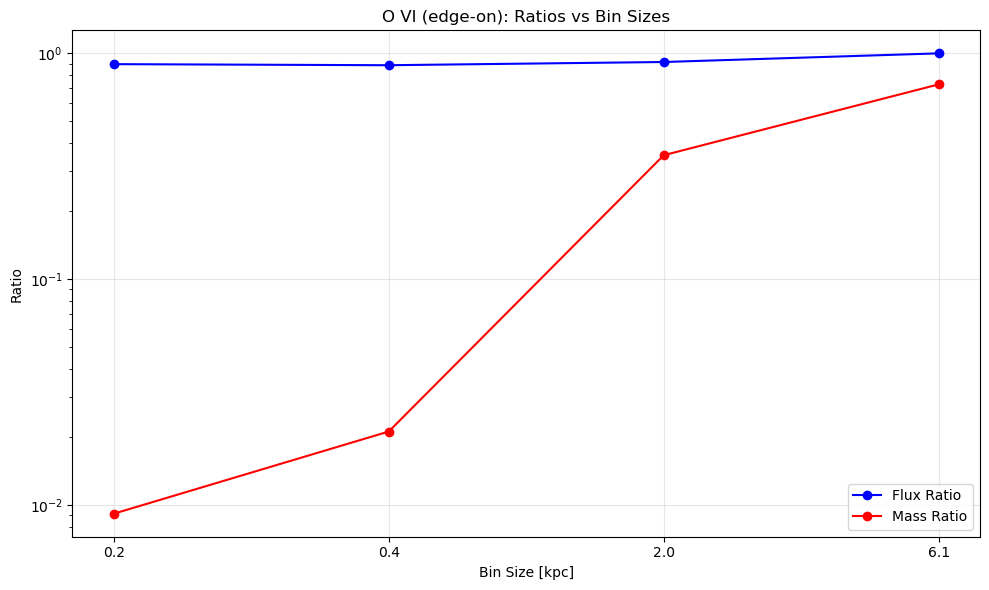

Orientation: face
emission_data min 312916460.8002342
Bin Size: 0.2 kpc
Total Flux: 2.03e+27, Flux Above Threshold: 1.82e+27, Flux Ratio: 0.90
Total Mass: 1.38e+05, Mass Above Threshold: 1.13e+03, Mass Ratio: 0.01
emission_data min 1579402706.8946767
Bin Size: 0.4 kpc
Total Flux: 1.48e+27, Flux Above Threshold: 1.30e+27, Flux Ratio: 0.88
Total Mass: 1.38e+05, Mass Above Threshold: 2.32e+03, Mass Ratio: 0.02
emission_data min 313133432056.2191
Bin Size: 2.0 kpc
Total Flux: 3.81e+26, Flux Above Threshold: 3.47e+26, Flux Ratio: 0.91
Total Mass: 1.37e+05, Mass Above Threshold: 5.77e+04, Mass Ratio: 0.42
emission_data min 656200116742416.6
Bin Size: 6.1 kpc
Total Flux: 1.23e+28, Flux Above Threshold: 1.23e+28, Flux Ratio: 1.00
Total Mass: 1.35e+05, Mass Above Threshold: 1.11e+05, Mass Ratio: 0.82


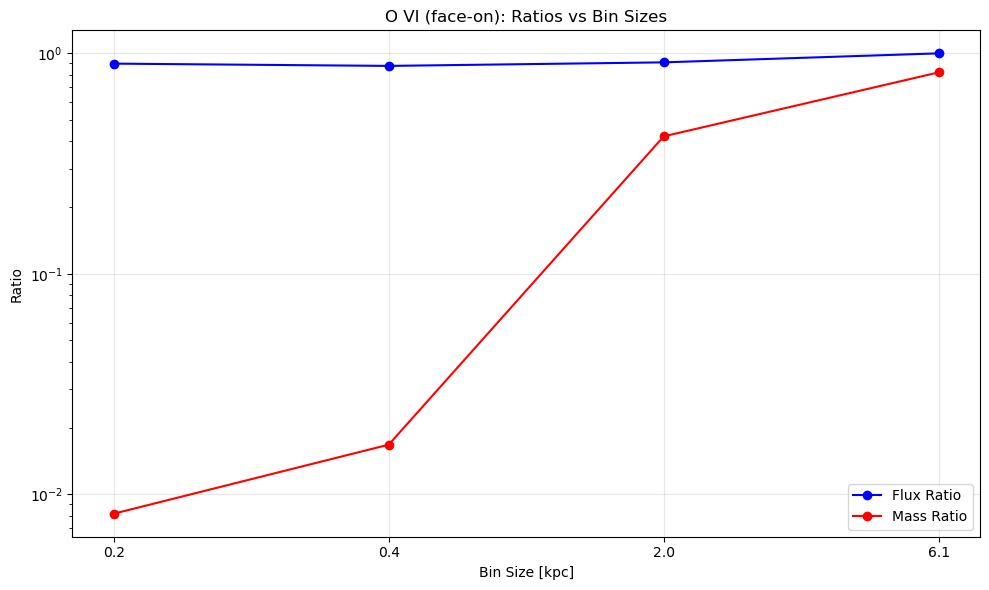

In [52]:
# Define parameters
ions = ["C IV", "O VI"]
orientations = ["edge", "face"]
bin_sizes = ['0.2', '0.4', '2.0', '6.1']
flux_threshold = 1e22  # Define flux threshold
cmap = mtcm.get_cmap('Set1', len(bin_sizes))  # Colormap for plots

# Lists to store results
flux_ratios = []
mass_ratios = []

# Iterate over ions and orientations
for ion in ions:
    print(f"Ion: {ion}")
    for orientation in orientations:
        print(f"Orientation: {orientation}")
        
        flux_ratio_list = []
        mass_ratio_list = []

        for i, bin_size_kpc in enumerate(bin_sizes):
            save_path = prefix + f'FRBs/res_{bin_size_kpc}/'
            file_path = save_path + halo_name + '_emission_maps' + '.hdf5'

            # Open the HDF5 file and extract emission and mass data
            with h5py.File(file_path, 'r') as f:
                emission_data = np.array(f[f"z=0.0/{ion}_emission_{orientation}_all"]).flatten()
                mass_data = np.array(f[f"z=0.0/{ion}_mass_{orientation}_all"]).flatten()
                valid_indices = (emission_data > 1e-140) & (mass_data > 1e-140)
                emission_data = emission_data[valid_indices]*((float(bin_size_kpc)*3.086e21)**2)
                print('emission_data min',emission_data.min())
                
                mass_data = mass_data[valid_indices]
                # Total flux and mass
                total_flux = emission_data.sum()
                total_mass = mass_data.sum()

                # Filter for flux above the threshold
                
                flux_above_threshold = emission_data[emission_data > flux_threshold].sum()
                mass_above_threshold = mass_data[emission_data > flux_threshold].sum()

                # Calculate ratios
                flux_ratio = flux_above_threshold / total_flux if total_flux > 0 else 0
                mass_ratio = mass_above_threshold / total_mass if total_mass > 0 else 0

                # Print metrics
                print(f"Bin Size: {bin_size_kpc} kpc")
                print(f"Total Flux: {total_flux:.2e}, Flux Above Threshold: {flux_above_threshold:.2e}, Flux Ratio: {flux_ratio:.2f}")
                print(f"Total Mass: {total_mass:.2e}, Mass Above Threshold: {mass_above_threshold:.2e}, Mass Ratio: {mass_ratio:.2f}")

                # Append to lists
                flux_ratio_list.append(flux_ratio)
                mass_ratio_list.append(mass_ratio)

        # Store ratios for this ion and orientation
        flux_ratios.append((ion, orientation, flux_ratio_list))
        mass_ratios.append((ion, orientation, mass_ratio_list))

        # Plot flux ratio and mass ratio vs bin sizes
        plt.figure(figsize=(10, 6))
        plt.plot(bin_sizes, flux_ratio_list, label='Flux Ratio', marker='o', linestyle='-', color='blue')
        plt.plot(bin_sizes, mass_ratio_list, label='Mass Ratio', marker='o', linestyle='-', color='red')
        plt.xlabel('Bin Size [kpc]')
        plt.ylabel('Ratio')
        plt.yscale('log')  # Optional: Use log scale if needed
        #plt.ylim(0.2,1.1)
        plt.title(f'{ion} ({orientation}-on): Ratios vs Bin Sizes')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_dir = os.path.join(prefix, "ratios_vs_bin_sizes", orientation)
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, f"{ion.replace(' ', '_')}_{orientation}_ratios.png"))
        plt.show()

# The flux_ratios and mass_ratios lists now contain data for all bin sizes.
